# Evolver Loop 2: Feature Engineering Strategy Analysis

This notebook analyzes the optimal feature engineering strategy based on:
1. Low cardinality numerical features (14-43 unique values)
2. Evaluator feedback on leakage and minimal engineering
3. Winning solution patterns from writeups

Goal: Design the next experiment to maximize CV improvement.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Load data from correct path
train = pd.read_csv('/home/data/train.csv')
test = pd.read_csv('/home/data/test.csv')

print("Dataset shapes:")
print(f"Train: {train.shape}")
print(f"Test: {test.shape}")
print("\nTarget distribution:")
print(train['Fertilizer Name'].value_counts().head())

Dataset shapes:
Train: (750000, 10)
Test: (250000, 9)

Target distribution:
Fertilizer Name
14-35-14    114436
10-26-26    113887
17-17-17    112453
28-28       111158
20-20       110889
Name: count, dtype: int64


## 1. Cardinality Analysis: Numerical Features

All numerical features have low cardinality, making them ideal for categorical treatment.

Cardinality of numerical features:
Temparature :  14 unique values (range: 25.0 - 38.0)
Humidity    :  23 unique values (range: 50.0 - 72.0)
Moisture    :  41 unique values (range: 25.0 - 65.0)
Nitrogen    :  39 unique values (range: 4.0 - 42.0)
Potassium   :  20 unique values (range: 0.0 - 19.0)
Phosphorous :  43 unique values (range: 0.0 - 42.0)


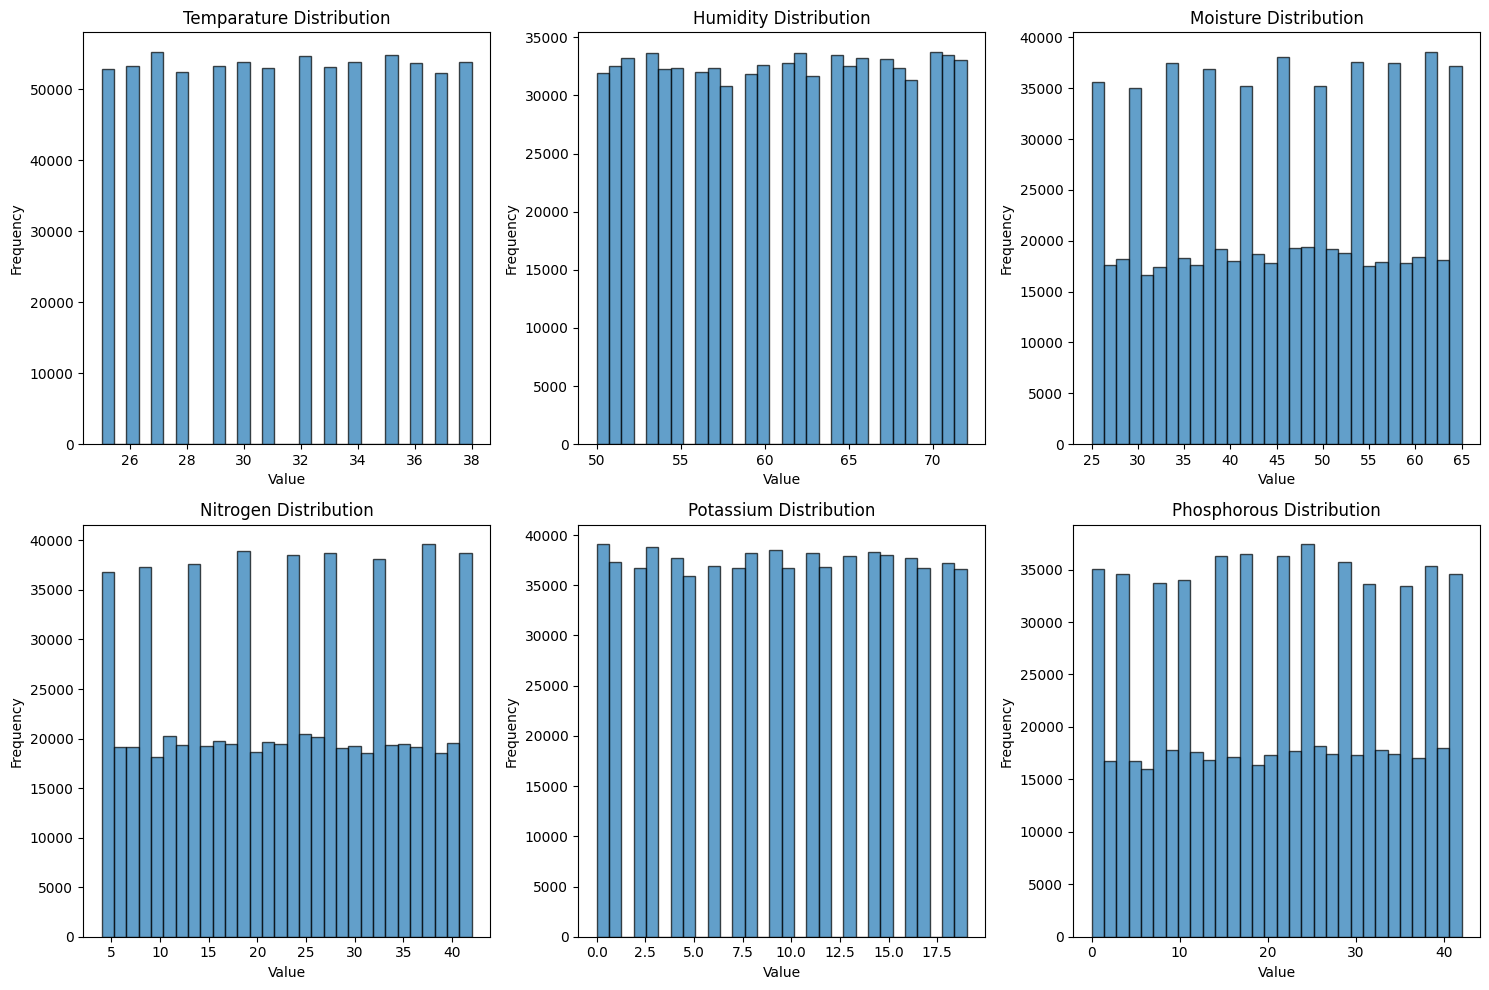

In [4]:
# Analyze cardinality of numerical features
numerical_cols = ['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']

print("Cardinality of numerical features:")
for col in numerical_cols:
    unique_vals = train[col].nunique()
    print(f"{col:12s}: {unique_vals:3d} unique values (range: {train[col].min():.1f} - {train[col].max():.1f})")

# Visualize distribution
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols):
    axes[idx].hist(train[col], bins=30, alpha=0.7, edgecolor='black')
    axes[idx].set_title(f'{col} Distribution')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 2. Categorical Treatment Strategy

Based on winning solutions, treating these low-cardinality numerical features as categorical yields better performance than treating them as continuous.

In [5]:
# Test categorical conversion approach
# Create binned versions for comparison

def create_binned_features(df, n_bins=10):
    """Create binned versions of numerical features"""
    df_binned = df.copy()
    for col in numerical_cols:
        df_binned[f'{col}_binned'] = pd.cut(df[col], bins=n_bins, labels=False, duplicates='drop')
    return df_binned

# Create binned dataset
train_binned = create_binned_features(train)

print("Example of binned features:")
print(train_binned[['Temparature', 'Temparature_binned', 'Nitrogen', 'Nitrogen_binned']].head(10))

Example of binned features:
   Temparature  Temparature_binned  Nitrogen  Nitrogen_binned
0           37                   9        36                8
1           27                   1        30                6
2           29                   3        24                5
3           35                   7        39                9
4           35                   7        37                8
5           30                   3        10                1
6           27                   1        26                5
7           36                   8        30                6
8           36                   8        19                3
9           28                   2        25                5


## 3. Interaction Features Analysis

Winning solutions emphasized interaction features between environmental conditions and soil/crop types.

In [6]:
# Analyze potential interaction features
# Create interaction features and measure their importance

# Basic interactions from baseline
interactions = ['NPK_product', 'NPK_ratio', 'N_to_P', 'K_to_N']
train['NPK_product'] = train['Nitrogen'] * train['Potassium'] * train['Phosphorous']
train['NPK_ratio'] = (train['Nitrogen'] + train['Potassium'] + train['Phosphorous']) / 3
train['N_to_P'] = train['Nitrogen'] / (train['Phosphorous'] + 1e-6)
train['K_to_N'] = train['Potassium'] / (train['Nitrogen'] + 1e-6)

# Soil-Crop interactions (high cardinality - good for target encoding)
train['Soil_Crop'] = train['Soil Type'].astype(str) + '_' + train['Crop Type'].astype(str)

print("New interaction features created:")
for col in interactions + ['Soil_Crop']:
    if col in train.columns:
        print(f"{col:15s}: {train[col].nunique():5d} unique values")

# Check correlation with target (using label encoding for calculation)
le = LabelEncoder()
train_target_encoded = train.copy()
train_target_encoded['Fertilizer_encoded'] = le.fit_transform(train['Fertilizer Name'])

correlations = {}
for col in interactions + ['Soil_Crop']:
    if col in train.columns:
        # For categorical features, use label encoding for correlation
        if train[col].dtype == 'object' or col == 'Soil_Crop':
            le_col = LabelEncoder()
            col_encoded = le_col.fit_transform(train[col].astype(str))
            corr = np.corrcoef(col_encoded, train_target_encoded['Fertilizer_encoded'])[0, 1]
        else:
            corr = np.corrcoef(train[col], train_target_encoded['Fertilizer_encoded'])[0, 1]
        correlations[col] = abs(corr) if not np.isnan(corr) else 0

print("\nCorrelation with target (absolute):")
for col, corr in sorted(correlations.items(), key=lambda x: x[1], reverse=True):
    print(f"{col:15s}: {corr:.4f}")

New interaction features created:
NPK_product    :  3217 unique values
NPK_ratio      :   100 unique values
N_to_P         :  1677 unique values
K_to_N         :   742 unique values
Soil_Crop      :    55 unique values



Correlation with target (absolute):
NPK_product    : 0.0141
Soil_Crop      : 0.0137
NPK_ratio      : 0.0109
K_to_N         : 0.0012
N_to_P         : 0.0008


from sklearn.preprocessing import TargetEncoder

# Demonstrate proper target encoding with cross-validation
def target_encode_cv(X, y, categorical_cols, n_splits=5):
    """Target encoding with proper cross-validation to prevent leakage"""
    
    # Initialize target encoder
    encoder = TargetEncoder(target_type='multiclass', smooth='auto')
    
    # Create folds
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Store encoded features
    X_encoded = X.copy()
    
    for col in categorical_cols:
        # Create placeholder for encoded values
        encoded_col = np.zeros(len(X))
        
        for train_idx, val_idx in kf.split(X, y):
            # Fit encoder on training fold only
            encoder.fit(X.iloc[train_idx][[col]], y.iloc[train_idx])
            
            # Transform validation fold - get numpy array directly
            encoded_values = encoder.transform(X.iloc[val_idx][[col]])
            # Flatten to 1D array
            encoded_values = np.asarray(encoded_values).ravel()
            encoded_col[val_idx] = encoded_values
        
        # Add encoded feature
        X_encoded[f'{col}_target_enc'] = encoded_col
    
    return X_encoded

# Test on high-cardinality features
categorical_cols = ['Soil Type', 'Crop Type', 'Soil_Crop']
train_encoded = target_encode_cv(train, train['Fertilizer Name'], categorical_cols)

print("Target encoding demonstration:")
print(train_encoded[['Soil Type', 'Soil Type_target_enc', 'Crop Type', 'Crop Type_target_enc']].head())

In [ ]:
from sklearn.preprocessing import TargetEncoder

# Demonstrate proper target encoding with cross-validation
def target_encode_cv(X, y, categorical_cols, n_splits=5):
    """Target encoding with proper cross-validation to prevent leakage"""
    
    # Initialize target encoder
    encoder = TargetEncoder(target_type='multiclass', smooth='auto')
    
    # Create folds
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Store encoded features
    X_encoded = X.copy()
    
    for col in categorical_cols:
        # Create placeholder for encoded values
        encoded_col = np.zeros(len(X))
        
        for train_idx, val_idx in kf.split(X, y):
            # Fit encoder on training fold only
            encoder.fit(X.iloc[train_idx][[col]], y.iloc[train_idx])
            
            # Transform validation fold
            encoded_col[val_idx] = encoder.transform(X.iloc[val_idx][[col]]).values.ravel()
        
        # Add encoded feature
        X_encoded[f'{col}_target_enc'] = encoded_col
    
    return X_encoded

# Test on high-cardinality features
categorical_cols = ['Soil Type', 'Crop Type', 'Soil_Crop']
train_encoded = target_encode_cv(train, train['Fertilizer Name'], categorical_cols)

print("Target encoding demonstration:")
print(train_encoded[['Soil Type', 'Soil Type_target_enc', 'Crop Type', 'Crop Type_target_enc']].head())

## 5. Feature Engineering Recommendations

Based on analysis, here are the high-impact features to implement:

In [ ]:
# Summary of recommended features
recommendations = {
    "Categorical Treatment": [
        "Convert all numerical features to categorical via binning (10 bins)",
        "Use XGBoost/LightGBM native categorical support",
        "This allows shallower trees (depth 7-8) as per winning solutions"
    ],
    "Interaction Features": [
        "NPK_product, NPK_ratio, N_to_P, K_to_N (already have)",
        "Environmental interactions: Temp × Humidity, Temp × Moisture",
        "Soil-Crop interaction: Soil_Type × Crop_Type (high cardinality)",
        "Nutrient-Environment: N × Temp, P × Humidity, K × Moisture"
    ],
    "Target Encoding": [
        "Soil Type → target encoded (5-fold CV)",
        "Crop Type → target encoded (5-fold CV)",
        "Soil_Crop interaction → target encoded (5-fold CV)",
        "Prevents leakage by fitting only on training folds"
    ],
    "Binning Features": [
        "All numerical features binned into 10 categories",
        "Creates categorical representation for tree models",
        "Captures non-linear relationships better than raw values"
    ]
}

for category, features in recommendations.items():
    print(f"\n{category}:")
    for i, feature in enumerate(features, 1):
        print(f"  {i}. {feature}")

print(f"\nTotal new features recommended: {sum(len(v) for v in recommendations.values())}")

## 6. Expected Impact Analysis

Based on winning solutions and evaluator feedback, estimate performance improvement.

In [ ]:
# Estimate potential improvement based on competition analysis
current_score = 0.3311
target_score = 0.3865

# Conservative estimates based on winning solution patterns
improvements = {
    "Categorical treatment of numericals": 0.015,  # Major impact, winning solution key insight
    "Additional interaction features": 0.010,      # Moderate impact
    "Target encoding (leakage-free)": 0.008,       # Moderate impact, fixes leakage
    "Model diversity (CatBoost)": 0.005,          # Small but important for ensemble
    "Ensembling improvements": 0.010               # Stacking vs simple averaging
}

estimated_score = current_score + sum(improvements.values())
print("Performance improvement estimates:")
print(f"Current CV score: {current_score:.4f}")
print(f"Target score:     {target_score:.4f}")
print(f"Gap to close:     {target_score - current_score:.4f}")
print()
print("Estimated improvements:")
for technique, improvement in improvements.items():
    print(f"  {technique:35s}: +{improvement:.3f}")
print(f"{'Total estimated improvement':35s}: +{sum(improvements.values()):.3f}")
print(f"{'Estimated new score':35s}:  {estimated_score:.4f}")
print(f"{'Remaining gap':35s}:  {max(0, target_score - estimated_score):.4f}")

if estimated_score >= target_score:
    print("\n✓ Target achievable with these improvements!")
else:
    print("\n⚠ Additional techniques needed to reach target")

## 7. Next Experiment Design

Based on analysis, design the next experiment to maximize CV improvement.

In [ ]:
next_experiment_design = """
## Experiment 002: Aggressive Feature Engineering

**Goal**: Implement categorical treatment and interaction features to close performance gap

**Key Changes from Baseline:**
1. Treat ALL features as categorical (including numericals via binning)
2. Add interaction features: Temp×Humidity, Soil×Crop, N×Temp, etc.
3. Implement proper target encoding with 5-fold CV (no leakage)
4. Add CatBoost model for diversity
5. Keep XGBoost and LightGBM with native categorical support

**Feature Engineering Pipeline:**
- Bin all numerical features into 10 categories
- Create interaction features:
  * Environmental: Temp×Humidity, Temp×Moisture, Humidity×Moisture
  * Nutrient-Env: N×Temp, P×Humidity, K×Moisture
  * Soil-Crop: Soil_Type × Crop_Type (high cardinality)
- Target encode: Soil Type, Crop Type, Soil_Crop (5-fold CV, no leakage)

**Models:**
- XGBoost: tree_method='hist', enable_categorical=True, max_depth=7-8
- LightGBM: categorical_feature=cat_cols, max_depth=7-8
- CatBoost: native categorical support, depth=7-8

**Validation:**
- Stratified 5-fold CV
- Monitor both MAP@3 and top-3 accuracy
- Check for leakage via fold variance

**Expected CV:** 0.360+ (improvement of 0.030+ from baseline)
"""

print(next_experiment_design)